In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix ,recall_score, roc_auc_score , roc_curve, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        pred = np.where(pred>0.5, 1,0) ## To Find the Threshold use the Auc Roc Curve

        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        ConfusionMatrixDisplay.from_predictions(y_train, pred) 
        plt.show()
        
    elif train==False:
        pred = clf.predict(X_test)
        pred = np.where(pred>0.5, 1,0) ## To Find the Threshold use the Auc Roc Curve
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        ConfusionMatrixDisplay.from_predictions(y_test, pred) 
        plt.show()
        

pd.set_option('display.max_columns', 500)
   ### VIF SCORE : ---------->
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
def vif_score(x):
    scaler = StandardScaler()
    arr = scaler.fit_transform(x)
    return pd.DataFrame([[x.columns[i] , variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], 
                        columns = ["FEATURE" , "VARIANCE INFLATION FACTOR"]) 

In [2]:

data = pd.read_csv("WELFake_Dataset.csv",usecols=['title', 'label'])

In [3]:
data.head(2)

,title,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,NaN,1


In [4]:
print("shape of the data ", data.shape)
print("-"*121)
print(data.isnull().sum())
print("-"*100)
print(data.duplicated().value_counts())

shape of the data  (72134, 2)
-------------------------------------------------------------------------------------------------------------------------
title    558
label      0
dtype: int64
----------------------------------------------------------------------------------------------------
False    62352
True      9782
Name: count, dtype: int64


In [5]:
data = data.dropna().drop_duplicates().reset_index(drop = True)

In [6]:
data.shape

(62351, 2)

In [7]:
data.head(1)

,title,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1


In [8]:
## Get the independent feature
x = data.drop("label", axis =1 )

In [9]:
## Get the dependent feature 
y = data['label']

In [10]:
messages = x.copy()

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sentences = messages['title'].to_list()

corpus = [
    ' '.join(lemmatizer.lemmatize(word) for word in re.sub('[^a-zA-Z]', ' ', sentence.lower()).split() if word not in stop_words)
    for sentence in sentences
]

In [11]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [12]:
## unique_word in a data set 
yy = ([(i.split()) for i in x['title']])
unique_word_in_a_dataset = len(set([i for i in yy for i in i ]))
unique_word_in_a_dataset

83963

In [13]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Dense

In [14]:
### NOW WE Will Use One Hot Encoding 
from tensorflow.keras.preprocessing.text import one_hot

vocab_size = 5000

one_hot_rep = [one_hot(i, vocab_size) for i in corpus]

In [15]:
one_hot_rep[0]

[590, 4962, 568, 3287, 1057, 4365, 3890, 2895, 3252, 204, 705, 75]

In [16]:
corpus[0]

'law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video'

### Embedding Representation

In [17]:
max_sentence_length = max([len(i.split()) for i in corpus])
print("max_length of the sentence in the corpus list :--->", max_sentence_length)

max_length of the sentence in the corpus list :---> 47


In [18]:
## Pre - Padding 
sent_length = max_sentence_length
embedded_docs = pad_sequences(one_hot_rep, maxlen=max_sentence_length, padding='pre')
embedded_docs

array([[   0,    0,    0, ...,  204,  705,   75],
       [   0,    0,    0, ..., 3205, 1363,   75],
       [   0,    0,    0, ...,  700, 2804,  634],
       ...,
       [   0,    0,    0, ..., 1599, 4501, 1058],
       [   0,    0,    0, ..., 4317, 2821, 3270],
       [   0,    0,    0, ..., 1164, 3720, 3431]])

In [19]:
print("one hot representation 1st sentence:---->",one_hot_rep[0])
print("-"*130)
print("First Sentences:------------------------>",corpus[0])
print("-"*130)
print("embedded document of 1st sentence:------>",embedded_docs[0])

one hot representation 1st sentence:----> [590, 4962, 568, 3287, 1057, 4365, 3890, 2895, 3252, 204, 705, 75]
----------------------------------------------------------------------------------------------------------------------------------
First Sentences:------------------------> law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video
----------------------------------------------------------------------------------------------------------------------------------
embedded document of 1st sentence:------> [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  590 4962  568 3287 1057 4365 3890
 2895 3252  204  705   75]


## CREATING AN LSTM  MODEL ALONG WITH EMBEDDING LAYER

In [20]:
embedding_vector_feature = 40 ##feature Representation
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_feature, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
print(len(embedded_docs), y.shape)

62351 (62351,)


In [22]:
import numpy as np
x_final = np.array(embedded_docs)
y_final = np.array(y)

In [23]:
print("x_final.shape",x_final.shape)
print("y_final.shape",y_final.shape)

x_final.shape (62351, 47)
y_final.shape (62351,)


In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_final,y_final, test_size=0.5)

In [25]:
print("x_train.shape",x_train.shape)
print("x_test.shape",x_test.shape)

print("y_train.shape",y_train.shape)
print("y_test.shape",y_test.shape)

x_train.shape (31175, 47)
x_test.shape (31176, 47)
y_train.shape (31175,)
y_test.shape (31176,)


## Model Training

In [26]:
### Final Training 
model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=10, batch_size=64)

Epoch 1/10
488/488 [==============================] - 54s 101ms/step - loss: 0.3493 - accuracy: 0.8350 - val_loss: 0.2879 - val_accuracy: 0.8726
Epoch 2/10
488/488 [==============================] - 44s 90ms/step - loss: 0.2300 - accuracy: 0.9041 - val_loss: 0.2912 - val_accuracy: 0.8724
Epoch 3/10
488/488 [==============================] - 44s 91ms/step - loss: 0.1966 - accuracy: 0.9197 - val_loss: 0.3162 - val_accuracy: 0.8681
Epoch 4/10
488/488 [==============================] - 44s 90ms/step - loss: 0.1696 - accuracy: 0.9315 - val_loss: 0.3394 - val_accuracy: 0.8671
Epoch 5/10
488/488 [==============================] - 44s 91ms/step - loss: 0.1417 - accuracy: 0.9437 - val_loss: 0.3780 - val_accuracy: 0.8653
Epoch 6/10
488/488 [==============================] - 45s 93ms/step - loss: 0.1201 - accuracy: 0.9537 - val_loss: 0.4187 - val_accuracy: 0.8567
Epoch 7/10
488/488 [==============================] - 45s 93ms/step - loss: 0.1014 - accuracy: 0.9613 - val_loss: 0.4896 - val_accuracy

## PERFORMANCE METRICS AND ACCURACY :--->

In [27]:
y_pred = model.predict(x_test)

975/975 [==============================] - 18s 18ms/step


In [28]:
y_pred = np.where(y_pred>0.5, 1,0) ## To Find the Threshold use the Auc Roc Curve

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_test, y_pred)

array([[14863,  2254],
       [ 2403, 11656]], dtype=int64)

In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred)*100)

85.06222735437517


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     17117
           1       0.84      0.83      0.83     14059

    accuracy                           0.85     31176
   macro avg       0.85      0.85      0.85     31176
weighted avg       0.85      0.85      0.85     31176



975/975 [==============================] - 19s 20ms/step
Train Result:
Accuracy Score: 98.73%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.991105      0.982539  0.987265      0.986822      0.987290
recall         0.985889      0.988979  0.987265      0.987434      0.987265
f1-score       0.988490      0.985749  0.987265      0.987120      0.987269
support    17292.000000  13883.000000  0.987265  31175.000000  31175.000000
_______________________________________________


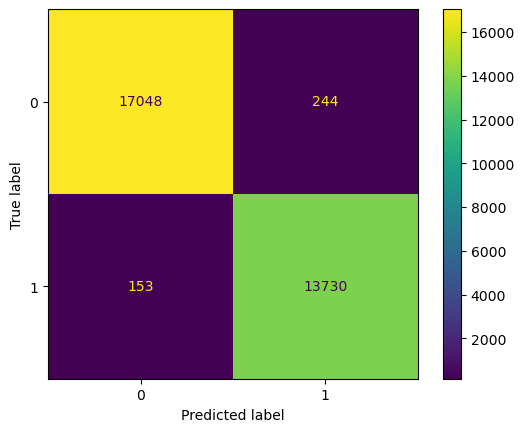

975/975 [==============================] - 23s 23ms/step
Test Result:
Accuracy Score: 85.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.860825      0.837958  0.850622      0.849392      0.850513
recall         0.868318      0.829077  0.850622      0.848698      0.850622
f1-score       0.864555      0.833494  0.850622      0.849025      0.850548
support    17117.000000  14059.000000  0.850622  31176.000000  31176.000000
_______________________________________________


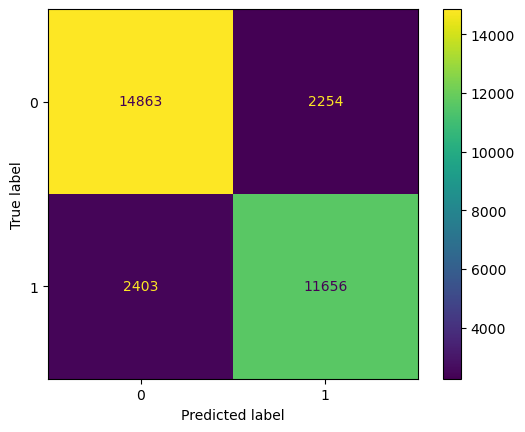

In [39]:
print_score(model, x_train, y_train, x_test, y_test, train=True)
print_score(model, x_train, y_train, x_test, y_test, train=False)